<a href="https://colab.research.google.com/github/jamescavanagh/unpackAI/blob/main/DL201/Chapter_06_multicat_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Multi Category Own Code 

Lesson 6 video from time 0:30:45 to 1:25:05

Own refactored code and notes for Chapter 6: *Multicat with Assignments* (['06_multicat.ipynb'](https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/06_multicat.ipynb))

Refactor the code for the Image Classifier "PASCAL_2007" 

Rewrite the code for the image classifier that identifies multiple objects in an image using PASCAL_2007; or, use your own data set that is properly labelled and has a big enough sample size.
- Only use the code necessary to load the data, create tbe DataLoaders, presize and or augment the images and then train the model using all the knowledge and tools you have learned from the book so far adding the new nowledge you have gained in this chapter.
- In this chapter we are focussing on multi lables, make sure that you show how you have set up your data and the results in your work
- Feel free to add any code that you perfer to use and make a note in the code as to why you perferred to use that code
- Add your own comments that can be used for reference in the future.

## Questionaire

###**How could multi-label classification improve the usability of the bear classifier?**
We could allow the model to predict that there are no bears present, since a multi-class classifcation model is forced to predict the presense of a bear even when there is none. 
###       **How do we encode the dependent variable in a multi-label classification problem?**
As a one-hot vector that can be operated on by pytorch. It ensures that each vector is the same size, and that it is indexed so that the pytorch can grab it quickly. 

### What is the difference between a Dataset and DataLoader?
A dataset is a collection which returns a tuple of the independent and depend variable for a single item. A dataloader is an iterator that takes mini batches from the dataset, and loads them with the dependent and independant variable.


### **What does a Datasets object normally contain?
A TRAINING SET AND A VALIDATION SET


###        **What does a DataLoaders object normally contain?
A training dataloader and a validation dataloader

### What are the methods to customize how the independent and dependent variables are created with the data block API?
Get_x is used for the independent variables. 
get_y specifies the labeling of the data points


### Why is softmax not an appropriate output activation function when using a one hot encoded target?
Softmax requires all predictions to add up to one, because it forces the model to make a single prediction when it could be that multiple catagories or no catagories appear in an image. 


### Why is nll_loss not an appropriate loss function when using a one-hot-encoded target?
The model needs to predict only one class, which is too narrow for multi catagory problems
### What is the difference between nn.BCELoss and nn.BCEWithLogitsLoss?
nn.BCE does not have a sigmoid function because it assumes that it has already been applied. nn.BCEWithLogitsLoss does both the sigmod and cross entropy in a single function
### Why can't we use regular accuracy in a multi-label problem?
Again, it assumes that there is only one answer, when this is not th eclase. Rather an activation threshold should be used in order to chose the final predictied classes.
### When is it okay to tune a hyperparameter on the validation set?
When they have a smooth relationship, we can assume that it will behave nicely, where if it is irratic and scattered, it may pick an outliar which would mess up the model. 

### What is a regression problem? What loss function should you use for such a problem?
A regression problem implies that there is a continous relationship between the dependent and independent variables unlike classification problems, for this we can use the mean squared error loss function. 
What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?
Use the correct DataBlock. 

###Imports and Setup

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

###Preparing the data

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

df = pd.read_csv(path/'train.csv')
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)


x,y = dsets.train[0]

dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)

#def get_x(r): return r['fname']
#def get_y(r): return r['labels']

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')


dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
#dsets.train[0]

In [ ]:
# Removed code that explained how the 
# Datatype needed to 
idxs = torch.where(dsets.train[0][1]==1.)[0]

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)


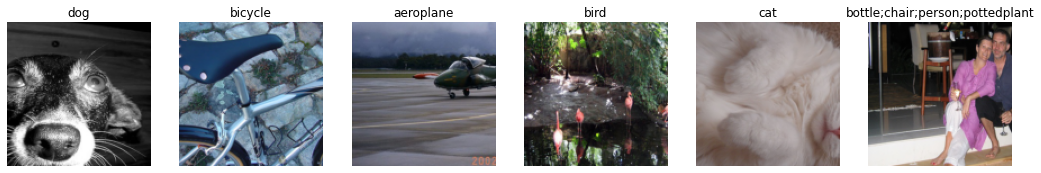

In [ ]:
dls.show_batch(nrows=1, ncols=6)

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
#activs.shape

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.949381,0.698572,0.234482,00:32
1,0.823917,0.568457,0.290159,00:32
2,0.601767,0.214257,0.778845,00:32
3,0.357202,0.123658,0.941952,00:32


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.137193,0.127758,0.937510,00:33
1,0.117892,0.109203,0.950996,00:32
2,0.098821,0.104905,0.950717,00:32


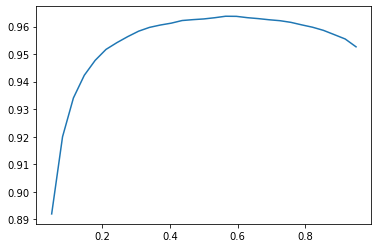

In [ ]:
preds,targs = learn.get_preds()

xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941463,0.694607,0.630259,00:32
1,0.817738,0.554944,0.741713,00:32
2,0.599877,0.204253,0.948984,00:32
3,0.358717,0.125014,0.957570,00:32


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131217,0.118478,0.959263,00:33
1,0.115946,0.107099,0.962350,00:33
2,0.097098,0.103667,0.964183,00:33


## Regression

###Assemble the data

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
Path.BASE_PATH = path

img_files = get_image_files(path)

def img2pose(x): 
    return Path(f'{str(x)[:-7]}pose.txt')

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

# see documentation fpr genfromtxt here: https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html

def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)), 
                 Normalize.from_stats(*imagenet_stats)]
                 )

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


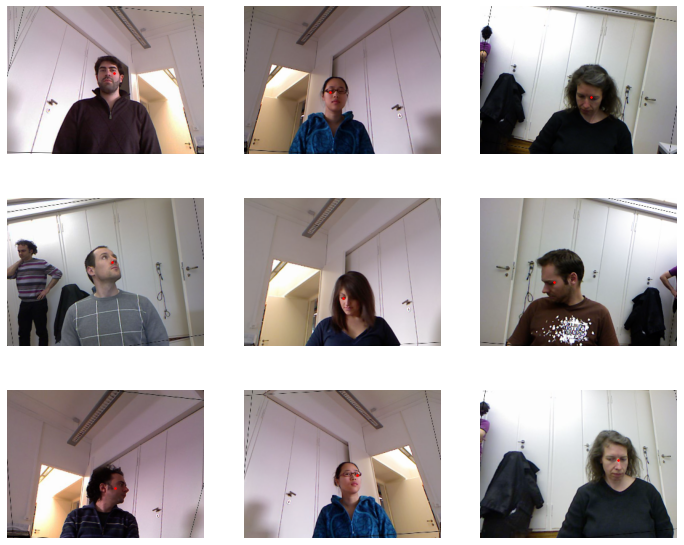

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(12,10))

###Train the model

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi-lo) + lo

SuggestedLRs(valley=tensor(0.0017))

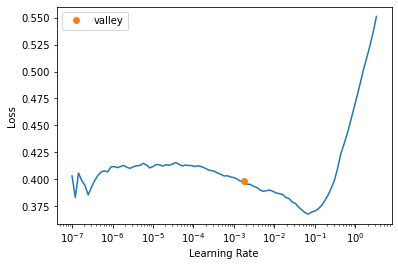

In [ ]:
learn.lr_find()

In [ ]:
lr = 1.7e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.051429,0.016856,02:10


epoch,train_loss,valid_loss,time
0,0.007202,0.002034,02:15
1,0.002173,0.000116,02:15
2,0.001162,0.000069,02:15


###Evaluate the results and test the model

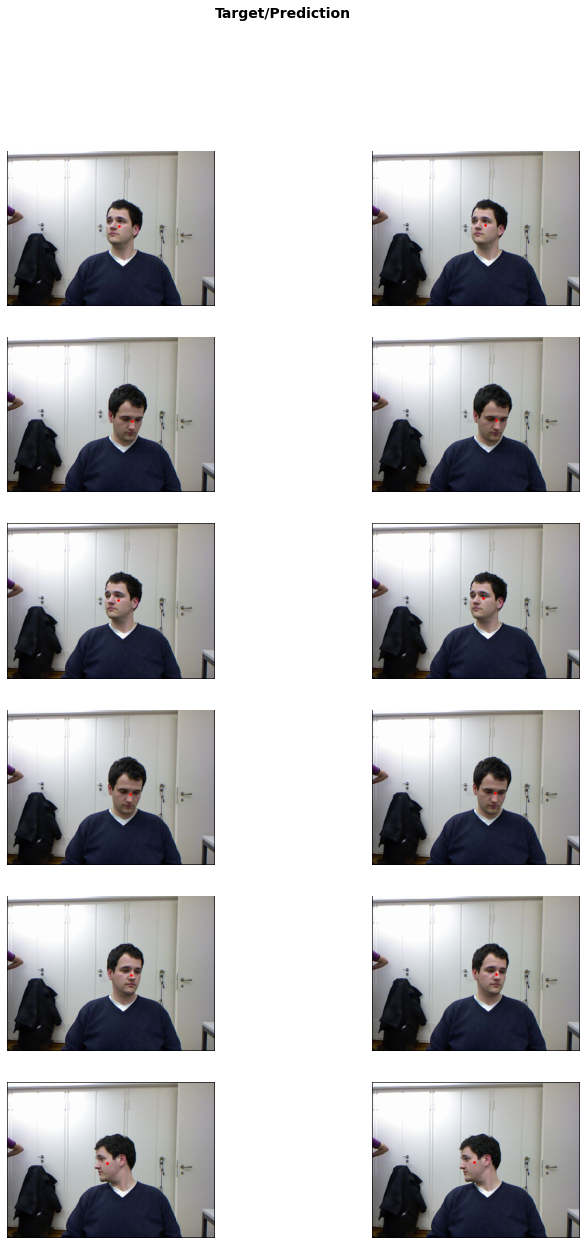

In [ ]:
learn.show_results(ds_idx=1, nrows=6, figsize=(12,20))